In [1]:
%matplotlib inline 
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
print(torch.cuda.is_available())

True


### Multi-GPU Trainning Step by Step

In [3]:
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

#### Define a Model----LeNet

In [4]:
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2,2), stride=2)
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2,2), stride=2)
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

loss = nn.CrossEntropyLoss(reduction='none')

#### Move Params to GPU

In [5]:
# move layers' parameters to different GPU
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]  # clone params to GPU and save in 'new_params'
    for p in new_params:
        p.requires_grad_()        # get gradient of all params
    return new_params

new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


#### Define a Function to Add up Vectors and Broadcast the Result back to GPUs

In [6]:
def allreduce(data):
    for i in range(1, len(data)):  # from GPU1 to GPUn
        data[0][:] += data[i].to(data[0].device)   # first copy data on GPUi to GPU0, then add 
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)  # after adding, restore the data to the former GPU
        
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('before allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
before allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


#### Distribute Data

In [7]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)   # split the data evenly
print('input :',data)
print('load into :', devices)
print('output :', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into : [device(type='cuda', index=0), device(type='cuda', index=1)]
output : (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


#### Split both Data and Labels

In [8]:
def split_batch(X, y, devices):
    assert X.shape[0] == y.shape[0] # chech whether the num of samples and num of labels is same
    return (nn.parallel.scatter(X, devices), nn.parallel.scatter(y, devices))

In [9]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # get one part of X&Y, then put them into lenet to get the loss, then get the sum
    ls = [loss(lenet(X_shard, device_W), y_shard).sum() 
          for X_shard, y_shard, device_W in zip(X_shards, y_shards, device_params)]
    # for each GPU, do the back prop        
    for l in ls:
        l.backward()
    with torch.no_grad():  # use 'with torch.no_grad' to make the computation without affecting the grad
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    for param in device_params:  # params are updated separately on each GPU
        d2l.sgd(param, lr, X.shape[0])

In [10]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    devices_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()   # start timing
        for X, y in train_iter:
            train_batch(X, y, devices_params, devices, lr)
            torch.cuda.synchronize()   # when all GPUs have done work, then synchronize all of them
        timer.stop()    # finish timing
        animator.add(
            epoch + 1, (d2l.evaluate_accuracy_gpu(lambda x: lenet(x, devices_params[0]), test_iter, devices[0],))
                )
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch'
             f'on {str(devices)}')

test acc: 0.83, 1.4 sec/epochon [device(type='cuda', index=0)]


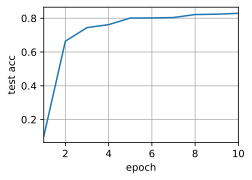

In [11]:
train(num_gpus=1, batch_size=256, lr=0.2)

test acc: 0.83, 1.5 sec/epochon [device(type='cuda', index=0), device(type='cuda', index=1)]


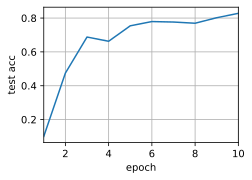

In [12]:
train(num_gpus=2, batch_size=512, lr=0.5) 
# acc will decrease when batch size double
# so we have to enlarge the lr

### Multi-GPU Trainning easily by PyTorch

In [13]:
def resnet18(num_classes, in_channels=1):
    def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)
    
    net = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64), nn.ReLU()
                        )
    net.add_module("resnet block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet block2", resnet_block(64, 128, 2))
    net.add_module("resnet block3", resnet_block(128, 256, 2))
    net.add_module("resnet block4", resnet_block(256, 512, 2))
    net.add_module("global average pooling", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fully connected", nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))
    return net

In [14]:
net = resnet18(10)
devices = d2l.try_all_gpus()

In [15]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    print(devices)
    
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
            
    net.apply(init_weights)
    # nn.DataParallel = copy net's params to each GPU; then return a new 'net'
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch'
        f'on {str(devices)}')

test acc: 0.93, 12.2 sec/epochon [device(type='cuda', index=0)]


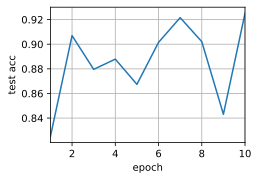

In [16]:
train(net, num_gpus=1, batch_size=256, lr=.1)  
# oscillation is violent since the lr is big. We only foucs on the last several epochs
# if lr is too small, at the last several epochs, it is hard to learn and become very slow

test acc: 0.89, 8.2 sec/epochon [device(type='cuda', index=0), device(type='cuda', index=1)]


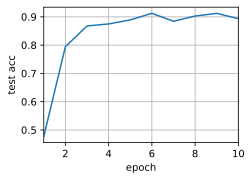

In [17]:
train(net, num_gpus=2, batch_size=256*4, lr=.1*2)